In [1]:
# -*- coding: utf-8 -*-
"""
@author: J. Salmon, A. Gramfort, C. Vernade
Modified on Sun Nov 10 15:06:14 2019 by mozharovskyi.
"""

###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1],
                        c=np.reshape(color_blind_list[label_num], (1, -1)),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

###############################################################################
#               Algorithms and functions
###############################################################################


class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))


# EX1

Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que ren- voient ces fonctions ? À quoi correspond la dernière colonne ? Générez les données en utilisant chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers prenez 150 pour les deux premiers arguments; pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1,1)⊤, (−1,−1)⊤ et (1,−1)⊤, tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

*Jeux de données #1 - rand_bi_gauss:*
<br>
Output: 2 groups (Y = 1, -1) de données, avec X suit des lois Normale de (mu1, sigmas1) et (mu2, sigmas2)

In [5]:
X1, Y1 = rand_bi_gauss(n1=150, n2=150, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

*Jeux de données #2 - rand_tri_gauss:*
<br>
Output: 3 groups (Y = 1, 2, 3) de données, avec X suit des lois Normale de (mu1, sigmas1), (mu2, sigmas2) et (mu3, sigmas3)

In [6]:
X2, Y2 = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1], mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9], sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

*Jeux de données #3 - rand_clown:*
<br>
Output: 2 groups (Y = 1, -1) de données, avec X suit deux lois Normale.

In [7]:
X3, Y3 = rand_clown(n1=150, n2=150, sigma1=0.9, sigma2=0.9)

*Jeux de données #4 - rand_checkers:*
<br>
Output: 2 groups (Y = 1, 2, 3) de données, avec X suit plusieurs lois Normale.

In [8]:
X4, Y4 =  rand_checkers(n1=150, n2=150, sigma=0.9)

# EX 2

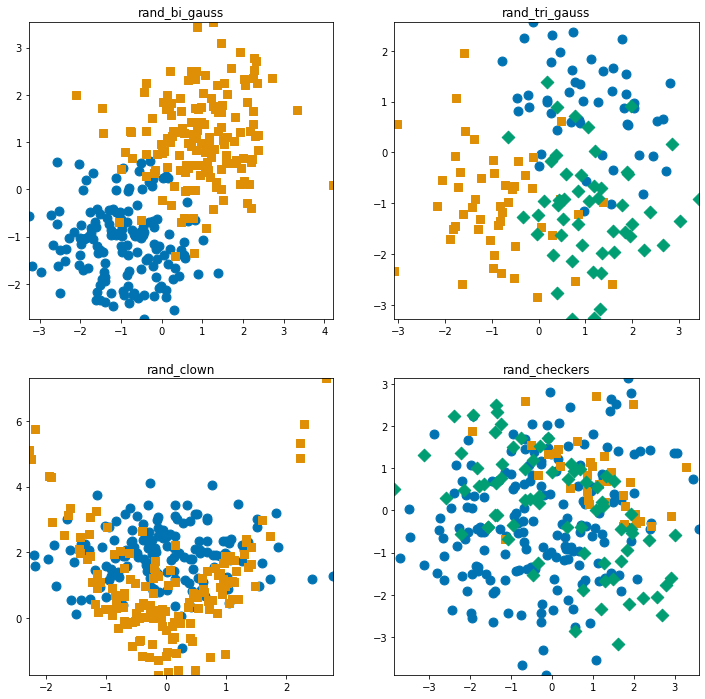

In [9]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(12,12))
           
plt.subplot(221)
plt.title('rand_bi_gauss')
plot_2d(X1, Y1, w=None, alpha_choice=1)
plt.subplot(222)
plt.title('rand_tri_gauss')
plot_2d(X2, Y2, w=None, alpha_choice=1)
plt.subplot(223)
plt.title('rand_clown')
plot_2d(X3, Y3, w=None, alpha_choice=1)
plt.subplot(224)
plt.title('rand_checkers')
plot_2d(X4, Y4, w=None, alpha_choice=1)

# EX 3

- La méthode des k-plus proches voisins
<br>
Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y sont à valeurs réelles : Y = R.

On va parcourir chaque points, on va regarder les nombres de chaque class pour k plus proches voisin du point. 

# EX 4

Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification predict. Choisissez une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans Vk(x). Vérifier la validité des résultats en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de données #2. Vous proposerez votre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import stats
from sklearn import metrics

class KNNClassifier(BaseEstimator, ClassifierMixin):
    #Homemade Nearest neighbors classifier'''
    
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        self.X_ = X
        self.Y_ = y
        return self

    def predict(self, Xpred):
        distance = metrics.pairwise.euclidean_distances(Xpred, self.X_)
        distance_sorted_indexes = np.argsort(distance)
        neighbours_labels = self.Y_[distance_sorted_indexes[:, 0:self.n_neighbors]]
        mode, count = stats.mode(neighbours_labels, axis=1)
        return mode.reshape(len(mode))

# EX 5

Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique d(x, v) = ∥x − v∥2 et k = 5. Visualisez les règles de classification obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)


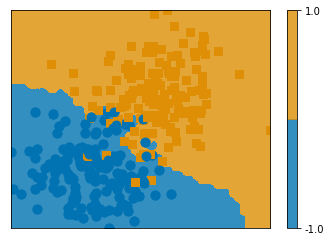

In [11]:
#method rand_bi_gauss
from sklearn.neighbors import KNeighborsClassifier
neigh = KNNClassifier(n_neighbors=5)
neigh.fit(X1,Y1)
plot_2d(X1, Y1, w=None, alpha_choice=1)

def func_neigh(a):
    return neigh.predict(a.reshape(1, -1))

frontiere_new(func_neigh, X1, Y1, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

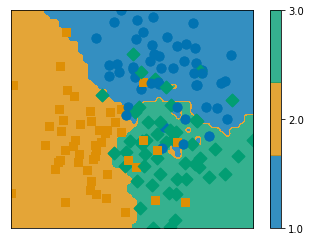

In [12]:
#method rand_tri_gauss
neigh = KNNClassifier(n_neighbors=5)
neigh.fit(X2,Y2) 
plot_2d(X2, Y2, w=None, alpha_choice=1)

def function(a):
        return neigh.predict(a.reshape(1, -1))

frontiere_new(function, X2, Y2, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

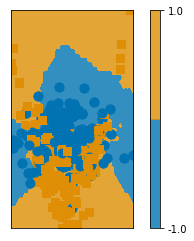

In [13]:
#method rand_clown
neigh = KNNClassifier(n_neighbors=5)
neigh.fit(X3,Y3) 

plot_2d(X3, Y3, w=None, alpha_choice=1)

def function(a):
        return neigh.predict(a.reshape(1, -1))
    
frontiere_new(function, X3, Y3, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

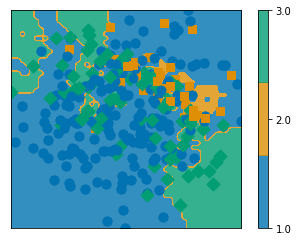

In [14]:
#method rand_checkers
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X4,Y4) 

plot_2d(X4, Y4, w=None, alpha_choice=1)

def function(a):
        return neigh.predict(a.reshape(1, -1))

frontiere_new(function, X4, Y4, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

# EX 6

Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris en compte : k = 1,2,...,n. Que devient la méthode dans le cas extrême où k = 1? k = n? Afficher ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

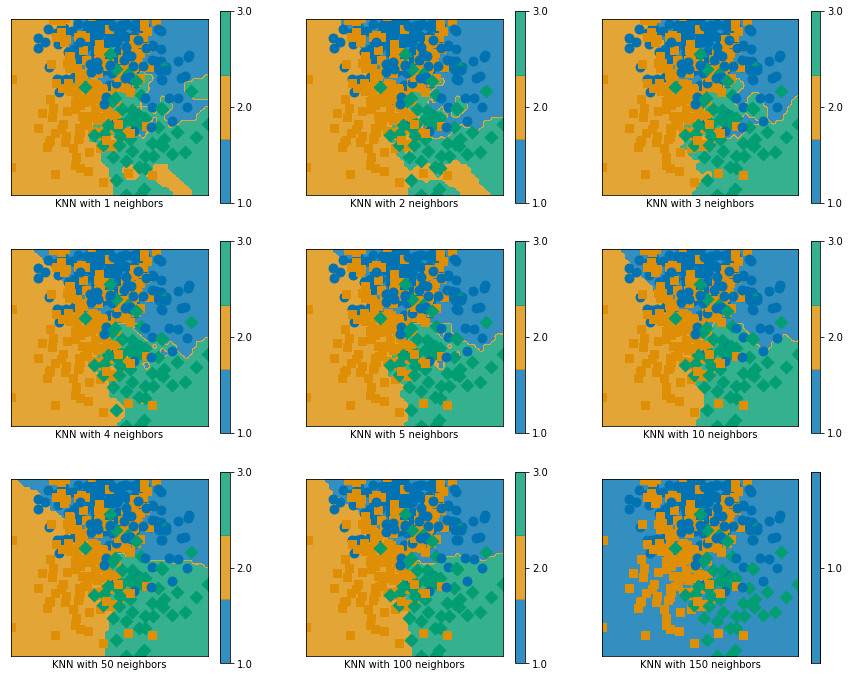

In [15]:
#method rand_tri_gauss
from sklearn.neighbors import KNeighborsClassifier
Ks = np.arange(1,6)
Ks = np.append(Ks, [10,50,100,150])
i = [331,332,333,334,335,336,337,338,339]
i = 331
plt.figure(figsize=(15,12))

for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X2,Y2) 
    plt.subplot(i)
    i = i + 1
    plt.xlabel('KNN with ' + str(k) + ' neighbors')
    plot_2d(X3, Y3, w=None, alpha_choice=1)    
    def function(a):
            return neigh.predict(a.reshape(1, -1))
    frontiere_new(function, X2, Y2, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

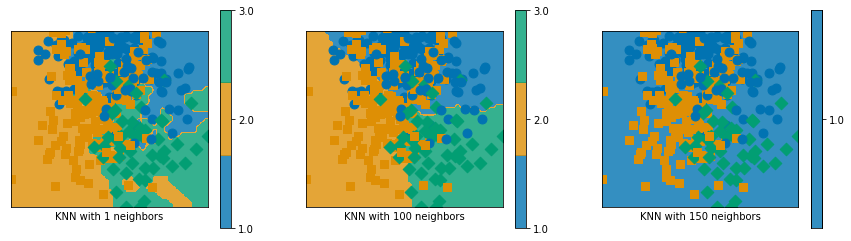

In [16]:
Ks = [1,100,150]
i = [131,132,133]
i = 131
plt.figure(figsize=(15,4))

for k in Ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X2,Y2) 
    plt.subplot(i)
    i = i + 1
    plt.xlabel('KNN with ' + str(k) + ' neighbors')
    plot_2d(X3, Y3, w=None, alpha_choice=1)    
    def function(a):
            return neigh.predict(a.reshape(1, -1))
    frontiere_new(function, X2, Y2, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

Conclusion:<br>
Le fontière devient plus en plus simple avec k plus en plus grand. 
- Quand k = 1, le modèle est overfit, chaque point est dans le bon catégorie.
- Quand k = 150, il n'y a qu'une seule prédiction, c'est celui qui a le plus grand nombre de pair. 

# EX 7

Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon e−d2j/h (h contrôlant le niveau de pondération)

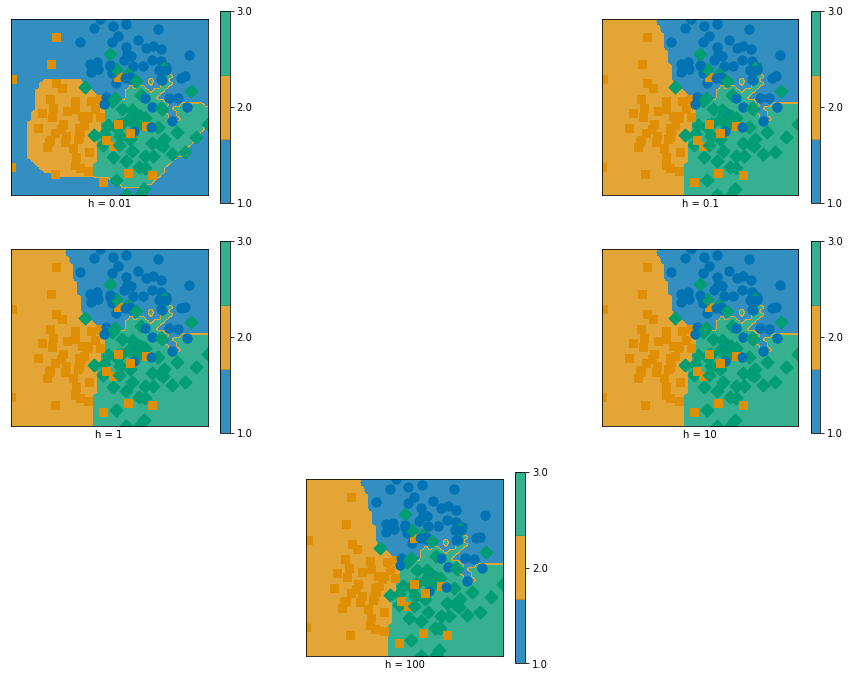

In [17]:
def func_weight(dist):
    return np.exp(-np.linalg.norm(dist)**2/h)

sp = [331,333,334,336,338]
k = 0
plt.close()
plt.figure(figsize=(15,12))
for j in range(-2,3):
    h = 10 ** j
    kneig_weight = neighbors.KNeighborsClassifier(n_neighbors=7, weights=func_weight)
    kneig_weight.fit(X2[0::2],Y2[0::2])
    def func(a):
        return kneig_weight.predict(a.reshape(1, -1))
    plt.subplot(sp[k])
    k += 1
    plt.xlabel('h = ' + str(h))
    plot_2d(X2,Y2)
    frontiere_new(func, X2, Y2, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

# EX 8

Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [18]:
import pandas as pd
result = pd.DataFrame({'pred': kneig_weight.predict(X2), 'Y': Y2 })

for j in range(-2,3):
    err_train = 0
    err_test = 0
    kneig_weight = neighbors.KNeighborsClassifier(n_neighbors=1)
    kneig_weight.fit(X2[0::2],Y2[0::2])
    
    for i in [1,2,3]:
        #train and test on data with indice of even value
        data_train = pd.DataFrame({'pred': kneig_weight.predict(X2[0::2]), 'Y': Y2[0::2]})        
        diff_train = len(data_train[(data_train['Y'] == i) & (data_train['pred'] != i)])
        err_train += diff_train/len(data_train['Y'] == i)
        #train and test on all data
        data_test = pd.DataFrame({'pred': kneig_weight.predict(X2), 'Y': Y2})
        diff_test = len(data_test[(data_test['Y'] == i) & (data_test['pred'] != i)])
        err_test += diff_test/len(data_test['Y'] == i)
    
    print('Pour j =', j, '. Lerreur de test est', err_test/3,'. Lerreur de train est', err_train/3)

Pour j = -2 . Lerreur de test est 0.06222222222222223 . Lerreur de train est 0.0
Pour j = -1 . Lerreur de test est 0.06222222222222223 . Lerreur de train est 0.0
Pour j = 0 . Lerreur de test est 0.06222222222222223 . Lerreur de train est 0.0
Pour j = 1 . Lerreur de test est 0.06222222222222223 . Lerreur de train est 0.0
Pour j = 2 . Lerreur de test est 0.06222222222222223 . Lerreur de train est 0.0


# EX 9

Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50. Vous pourrez utiliser la classe fournie ErrorCurve.

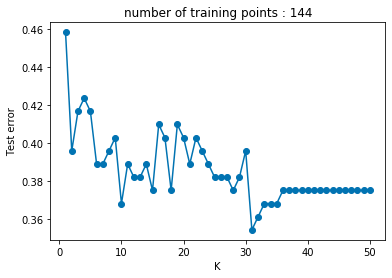

In [19]:
errorcurve = ErrorCurve(k_range=range(1,51), weights=func_weight)
errorcurve.fit_curve(X4[0::2],Y4[0::2],X4[1::2],Y4[1::2])
errorcurve.plot()

# EX 10

Tracez les différentes courbes d’erreur en fonction du paramètre k = (1,2,...,50) sur le jeu de données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)

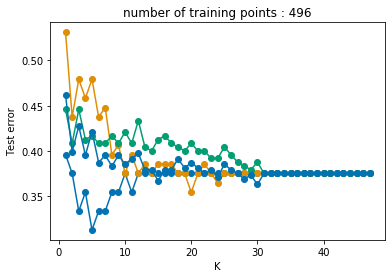

In [20]:
Ns = [100, 200, 500, 1000]
h = 10
for n in Ns:
    n1 = n/4
    n2 = n/4
    sigma = 0.9
    x1, y1 = rand_checkers(n1,n2,sigma)
    x2, y2 = rand_checkers(n1,n2,sigma)
    errorcurve = ErrorCurve(k_range=range(1,48), weights=func_weight)
    errorcurve.fit_curve(x1, y1, x2, y2)
    errorcurve.plot()
       

# EX 11

A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins : temps de calcul ? passage à l’échelle ? interprétabilité ?

Avantages:<br>
Simple à comprendre et à implémenter.
On peut l'utiliser sans à priori sur la distribution des données
<br><br>
Inconvénients:<br>
K doit être bien paramétré pour les modèles différentes, pour rendre une modèle juste et pas overfitted (sinon une anomalie locale va beaucoup influencer le résultat).
Le temps de calcul pour le trainig peut être long si le dataset de train est important.


# EX 12

Étudiez la base digits de scikit-learn. On pourra se référer à http://scikit-learn.org/stable/ _downloads/plot_digits_classification.py pour le chargement et la manipulation de la base de données. Pour de plus amples informations sur la nature de la classe 'Bunch' (une sous-classe de dictionnaire, on se reportera à la documentation sur la classe 'dict' : http://docs.python.org/ 2/library/stdtypes.html#mapping-types-dict. Décrivez la nature et le format des données (précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez le taux d’erreur.

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform'):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        88
           1       0.93      0.90      0.92        91
           2       0.92      0.92      0.92        86
           3       0.83      0.89      0.86        91
           4       0.99      0.95      0.97        92
           5       0.89      0.93      0.91        91
           6       0.96      1.00      0.98        91
           7       0.93      0.99      0.96        89
           8       0.96      0.77      0.86        88
           9       0.91      0.91      0.91        92

    accuracy                           0.93       899
   macro avg       0.93      0.93      0.92       899
weighted avg       0.93      0.93      0.92       899


Confusion matr

/Users/didi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


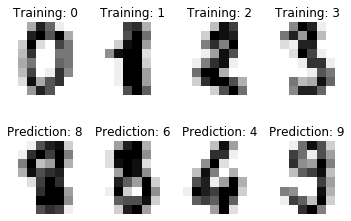

<class 'sklearn.utils.Bunch'>
Taux d'erreur : 0.07452725250278092


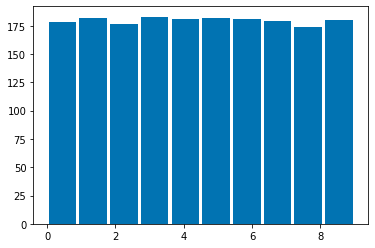

In [21]:
from sklearn import datasets, svm
from sklearn import datasets

digits = datasets.load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:6]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

#flatten image
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

classifier = neighbors.KNeighborsClassifier(n_neighbors=30)
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)
plt.show()

#plot histogram
print(type(digits))
plt.hist(digits.target, rwidth=0.9)

#calculate error
error =  1 - classifier.score(data[n_samples // 2:], digits.target[n_samples // 2:])
print('Taux d\'erreur : ' + str(error))


# EX 13

Estimez la matrice de confusion (P{Y = i, Ck(X) = j})i, j associée au classifieur Ck ainsi obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_ confusion_matrix.html.

Confusion matrix, without normalization
Normalized confusion matrix


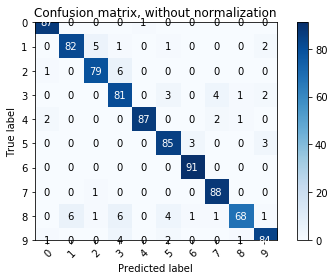

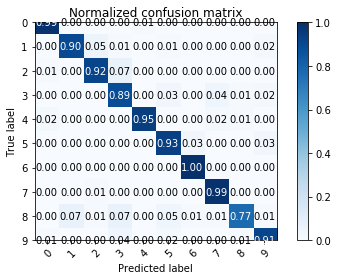

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #print title
    if not title:
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Matrice de confusion, sans normalisation')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(expected, predicted, classes=digits.target_names, normalize=False,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(expected, predicted, classes=digits.target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# EX 14

Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200. Pour plus d’information sur la validation croisée (cross- validation) on peut consulter [HTF09, Chapitre 7.10].

Le score est le meilleur quand k = 1 et k= 6.


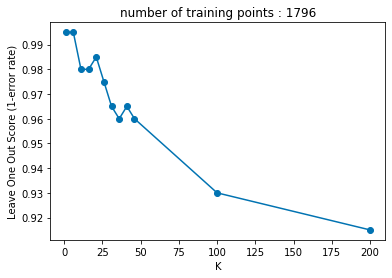

In [23]:
Ks = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
n_samples = len(digits.images)
loocurve = LOOCurve(k_range=Ks)
loocurve.fit_curve(data,digits.target)
plt.close()
loocurve.plot()
print("Le score est le meilleur quand k = 1 et k= 6.")

# EX 15

En utilisant la formule de Bayes donner la formule des probabilités a posteriori : P{Y = +1 | X = x}, P{Y =−1|X=x},commefonctionsdef+,f− etπ+.

On a:
\begin{align} 
 &P(Y = +1 | X = x)P(X = x) = P(X = x | Y = +1)P(Y = +1)
 \end{align}
On en déduit que:
\begin{align} 
 &P(Y=+1 \mid X=x) = \frac{f{-} \times \pi{-}}{f} \ &P(Y=-1 \mid X=x) = \frac{f{-} \times (1-\pi{+})}{f} \end{align}


# EX 16

Exprimer le log-ratio

$$ log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = log\left(\frac{f_+\pi_+}{f_-(1-\pi_+)}\right)$$
$$ \frac{f_+}{f_-} =  exp\left\{\frac{1}{2}\left[(x-\mu_-)^T \Sigma^{-1} (x-\mu_-) - \left((x-\mu_+)^T \Sigma^{-1} (x-\mu_+)\right)  \right]\right\}$$
$$ \frac{f_+}{f_-} =  exp\left\{-x^T\Sigma^{-1}\mu_-  + x^T\Sigma^{-1}\mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$
$$ \frac{f_+}{f_-} =  exp\left\{x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$
$$ log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+  + log\left(\frac{\pi_+}{(1-\pi_+)}\right)$$

$$ log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) = x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+  + log\left(\frac{\pi_+}{(1-\pi_+)}\right)$$

$$ {\mathbb{P}\{Y=+1|X=x\}} > {\mathbb{P}\{Y=-1|X=x\}}$$

# EX 17

If classifer = 1, on a:
\begin{equation} 
{\mathbb{P}\{Y=+1|X=x\}} > {\mathbb{P}\{Y=-1|X=x\}}\end{equation} 
\begin{equation}
log\left(\frac{\mathbb{P}\{Y=+1|X=x\}}{\mathbb{P}\{Y=-1|X=x\}}\right) > 0 \end{equation} 
\begin{equation} \frac12 \times [(x-\mu{-})^{T}\hat{\Sigma}^{-1}(x-\hat{\mu}{-})-(x-\hat{\mu}{+})^{T}\hat{\Sigma}^{-1}(x-\hat{\mu}{+})] + log(\frac{\pi{+}}{1-\pi{+}}) > 0\end{equation}
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}{+} - \hat{\mu}{-}) - \frac12 \times (\hat{\mu}^T{+} \hat{\Sigma}^{-1}\hat{\mu}^T{+} - \hat{\mu}^T{-} \hat{\Sigma}^{-1}\hat{\mu}^T{-}) + log(\frac{\pi{+}}{1-\pi{+}}) > 0\end{equation}
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}{+} - \hat{\mu}{-}) > \hat{\mu}^T{-} \hat{\Sigma}^{-1}\hat{\mu}^T{-}) - log(\frac{\pi{+}}{1-\pi{+}}) \end{equation} 
\begin{equation} \iff x^T \hat{\Sigma}^{-1}(\hat{\mu}{+} - \hat{\mu}{-}) > \hat{\mu}^T{-} \hat{\Sigma}^{-1}\hat{\mu}^T{-}) - log({\pi{+}}) - log({1-\pi{+}}) \end{equation}

or $\pi_{+} = \frac mn$ Ainsi on a bien le classifieur :

\begin{Bmatrix} 1& si & x^T \hat{\Sigma}^{-1}(\hat{\mu}{+} - \hat{\mu}{-}) > \hat{\mu}^T{-} \hat{\Sigma}^{-1}\hat{\mu}^T{-}) - log({\frac mn}) - log({1-\frac mn})
\end{Bmatrix}
\begin{Bmatrix} -1 & sinon \end{Bmatrix}

# EX 18

In [24]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.w = None
    
    def fit(self,X,y):
        xi_pos = []
        xi_neg = []
        for x_i,y_i in zip(X,y):
            if y_i == 1:
                xi_pos.append(x_i)
            else:
                xi_neg.append(x_i)
        
        var_pos = sum(xi_pos) / len(xi_pos)
        var_neg = sum(xi_neg) / len(xi_neg)
        
        sigma_pos = np.transpose((X - var_pos)).dot(X - var_pos)
        sigma_neg = np.transpose((X - var_neg)).dot(X - var_neg) 
        sigma = ((((len(xi_neg) - 1) * sigma_pos) + (len(xi_pos) - 1) * sigma_neg)) / (len(X) - 2)
        sigma_inv = np.linalg.inv(sigma)
        threshold = (0.5 * np.transpose(var_pos).dot(sigma_inv).dot(var_pos) - 0.5 * np.transpose(var_neg).dot(sigma_inv).dot(var_neg + np.log(1-len(xi_pos)/len(X)) - np.log(len(xi_pos)/len(X))))
        
        self.var_pos = var_pos
        self.var_neg = var_neg
        self.sigma_inv = sigma_inv
        self.threshold = threshold
    
    def predict(self,X_pred):
        pred = []
        for x_pred in X_pred:
            if np.transpose(x_pred).dot(self.sigma_inv).dot(self.var_pos - self.var_neg) > self.threshold :  
                pred.append(1)
            else:
                pred.append(-1)
        return pred
    
    def score(self,X_pred,y):
        return np.mean(np.equal(self.predict(X_pred),y))

# EX 19

Importez le module sklearn.discriminant_analysis qui contient en particulier la classe LinearDiscriminantAnalysis qui nous servira dans la suite. Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe LinearDiscriminantAnalysis de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m, i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez les taux d’erreur de LDAClassifier et de LinearDiscriminantAnalysis et le nombre de cas où les prédictions coïncident. En utilisant votre classe LDAClassifier, visualisez la règle de classification. (Vous pouvez utiliser la fonction frontiere_new.)

Taux d'erreur pour LDAClassifier :  0.040740740740740744
Taux d'erreur pour LinearDiscriminantAnalisys :  0.03703703703703709
Nombre de cas où les prédicitons coïncident :  267
Nombre total de prediction :270.
 Il y a donc une similitude de 98.88888888888889% dans la prédiction


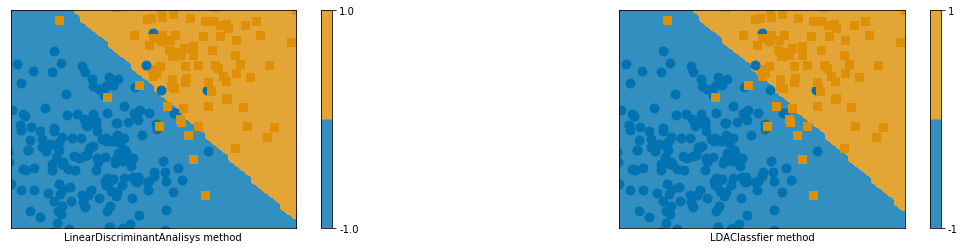

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n1 = 100
n2 = 200
mu1 = [1, 1]
mu2 = [-1, -1]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X5, Y5 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)
X5_train = X5[:len(X5) // 10]
Y5_train = Y5[:len(Y5) // 10]
X5_test = X5[len(X5) // 10:]
Y5_test = Y5[len(X5) // 10:]


LDA_skl = LinearDiscriminantAnalysis()
LDA_skl.fit(X5_train,Y5_train)

LDA_home = LDAClassifier()
LDA_home.fit(X5_train,Y5_train)

print("Taux d'erreur pour LDAClassifier : ", str( 1 - LDA_home.score(X5_test,Y5_test)))
print("Taux d'erreur pour LinearDiscriminantAnalisys : ", str( 1 - LDA_skl.score(X5_test,Y5_test)))
print("Nombre de cas où les prédicitons coïncident : ", str(len(X5_test[np.equal(LDA_home.predict(X5_test),LDA_skl.predict(X5_test))])))
print('Nombre total de prediction :' + str(len(X5_test)) + '.\n Il y a donc une similitude de ' + str(len(X5_test[np.equal(LDA_home.predict(X5_test),LDA_skl.predict(X5_test))]) / len(X5_test) * 100) + "% dans la prédiction" )

plt.figure(figsize=(20,4))

plt.subplot(122)
plt.xlabel('LDAClassfier method')
plot_2d(X5_test, Y5_test, w=None, alpha_choice=1)    
def func_LDA_home(a):
        return LDA_home.predict(a.reshape(1, -1))
frontiere_new(func_LDA_home, X5_train, Y5_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

plt.subplot(121)
plt.xlabel('LinearDiscriminantAnalisys method')
plot_2d(X5_test, Y5_test, w=None, alpha_choice=1)    
def func_LDA_skl(a):
        return LDA_skl.predict(a.reshape(1, -1))
frontiere_new(func_LDA_skl, X5_train, Y5_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
plt.show()



# EX 20

En utilisant votre classe LDAClassifier, visualisez la règle de classification pour les jeux de données #1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode dans ces deux cas.

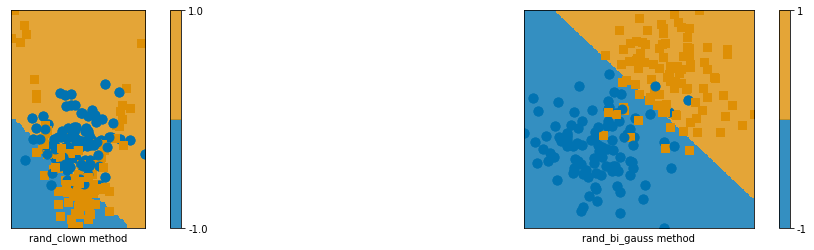

In [26]:
X1, Y1 = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])
X3, Y3 = rand_clown(n1=100, n2=100, sigma1=0.9, sigma2=0.9)

LDA_home_1 = LDAClassifier()
LDA_home_1.fit(X1,Y1)
LDA_home_3 = LDAClassifier()
LDA_home_3.fit(X3,Y3)

plt.figure(figsize=(20,4))

plt.subplot(122)
plt.xlabel('rand_bi_gauss method')
plot_2d(X1, Y1, w=None, alpha_choice=1)    
frontiere_new(func_LDA_home, X1, Y1, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

plt.subplot(121)
plt.xlabel('rand_clown method')
plot_2d(X3, Y3, w=None, alpha_choice=1)    
frontiere_new(func_LDA_skl, X3, Y3, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)
plt.show()

# EX 21

Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

In [27]:
from sklearn import linear_model

n1 = 20
n2 = 20000
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X6, Y6 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X6_train = X6[:len(X6) // 2]
Y6_train = Y6[:len(Y6) // 2]
X6_test = X6[len(X6) // 2:]
Y6_test = Y6[len(Y6) // 2:]

LogisticReg = linear_model.LogisticRegression()
LogisticReg.fit(X6_train,Y6_train)
LogisticReg_error = 1 - LogisticReg.score(X6_test,Y6_test)

LDA_skl = LinearDiscriminantAnalysis()
LDA_skl.fit(X6_train,Y6_train)
LDA_skl_error = 1 - LDA_skl.score(X6_test,Y6_test)
print("Erreur pour la regression logistique : " + str(LogisticReg_error))
print("Erreur pour l'analyse discriminante linéaire' : " + str(LDA_skl_error))
print("Conclusion: dans des cas de classes déséquilibrées, la méthode de Logistic Regression et la méthode LDA ont un taux d'erreur tous très faible.")

Erreur pour la regression logistique : 0.0008991008991009464
Erreur pour l'analyse discriminante linéaire' : 0.0008991008991009464
Conclusion: dans des cas de classes déséquilibrées, la méthode de Logistic Regression et la méthode LDA ont un taux d'erreur tous très faible.


/Users/didi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# EX 22

À quoi correspond la variable coef_ du modèle ? intercept_ ?

La frontière de décision s'écrit de la forme 
$$\alpha + \beta^TX $$. 
**coef_** correspond à $$\beta$$ et **intercept_** à $$\alpha$$


# EX 23

Utiliser la fonction frontiere_new pour visualiser la frontière de décision.

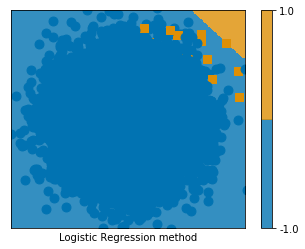

In [28]:
plt.xlabel('Logistic Regression method')
plot_2d(X6_test, Y6_test, w=None, alpha_choice=1)    
def func_LR(a):
        return LogisticReg.predict(a.reshape(1, -1))
frontiere_new(func_LR, X6_train, Y6_train, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

# EX 24

Appliquez la classification par régression logistique à des données issues de la base digits. Comme précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.

In [29]:
classifier_LS = linear_model.LogisticRegression(solver="lbfgs", multi_class='multinomial')
classifier_LS.fit(digits.data[:n_samples // 2], digits.target[:n_samples // 2])
LogisticReg_error = 1 - classifier.score(digits.data[n_samples // 2:], digits.target[n_samples // 2:])
print("Le taux derreur pour la regression logistique pour le dataset digits est ", LogisticReg_error)

Le taux derreur pour la regression logistique pour le dataset digits est  0.07452725250278092


/Users/didi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
